In [5]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


In [6]:
ticker='KPITTECH.NS'
df=yf.download(ticker,start='2020-01-01',end='2024-12-31')
df.describe()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,KPITTECH.NS,KPITTECH.NS,KPITTECH.NS,KPITTECH.NS,KPITTECH.NS
count,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,707.615717,722.314706,695.167773,709.027532,1.371902e+06
std,557.172500,567.194259,548.410141,558.816982,1.468728e+06
min,34.176174,35.843311,33.685842,34.617479,2.899000e+04
25%,169.507935,175.931289,167.203398,170.243465,5.799070e+05
50%,569.210266,586.626712,559.493803,572.069995,9.402810e+05
75%,1149.087646,1169.520842,1133.625937,1156.395904,1.609569e+06
max,1860.372070,1920.104680,1839.341244,1873.911495,1.698810e+07


In [7]:
df.head() #Date is present in 1st row
df.index=pd.to_datetime(df.index) # Converting index (1st row) to datetime for the date part, usually default datatype is string

In [8]:
print(df.isnull().sum()) #Checking for any null values are present

Price   Ticker     
Close   KPITTECH.NS    0
High    KPITTECH.NS    0
Low     KPITTECH.NS    0
Open    KPITTECH.NS    0
Volume  KPITTECH.NS    0
dtype: int64


In [9]:
#let's calculate 30 day SMA , 50 day SMA , 30 day EMA for now, if 30 day EMA/SMA breaks above 50 SMA then,
#uptrend if alter, then downtrend to be expected in normal

df['30 SMA']=df[('Close','KPITTECH.NS')].rolling(30).mean()
df['50 SMA']=df[('Close','KPITTECH.NS')].rolling(50).mean()
df['30 EMA']=df[('Close','KPITTECH.NS')].ewm(span=30,adjust=False).mean() 
# ema = x(1-x)*price_today + x(1-x)^2*price_yesterday + x(1-x)^3 * price_day_before_yesterday +...
# span in ema -> x=2/(span+1) 

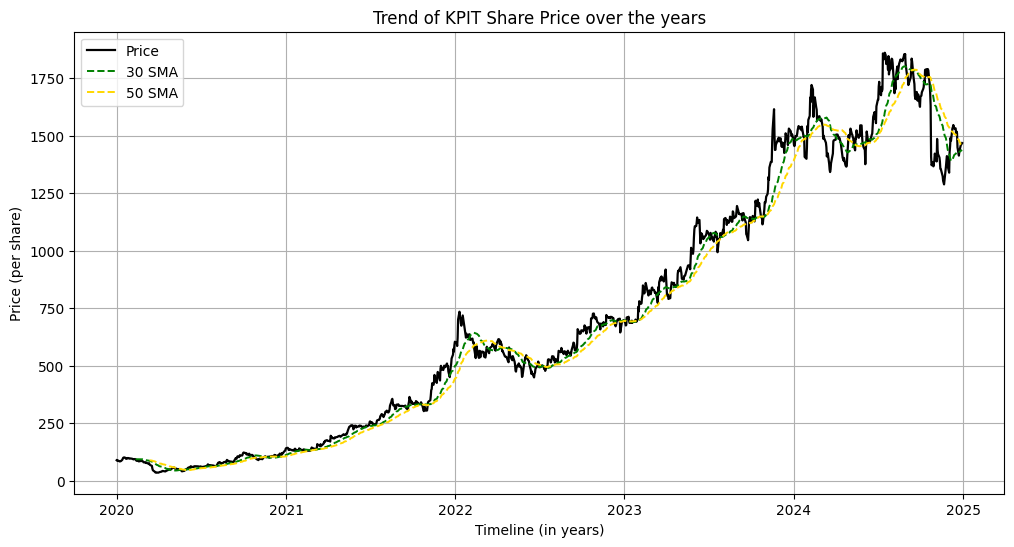

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'],label='Price',color='Black',linewidth=1.6)
plt.plot(df['30 SMA'],label='30 SMA',color='Green',linewidth=1.4,linestyle='--')
plt.plot(df['50 SMA'],label='50 SMA',color='Gold',linewidth=1.4,linestyle='--')
plt.title('Trend of KPIT Share Price over the years')
plt.xlabel('Timeline (in years)')
plt.ylabel('Price (per share)')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# RSI -> Relative Strength Index ; Its ratio of Avg. Gain / Avg. Loss 
# which is normalized in the range bound between 0 to 100, typically calculated over a period of 14 days.
# RSI above 70 is considered as Overbought Zone
# RSI below 30 is considered as Oversold Zone
# RSI in mid range of 50 is considered as normal

def RSI_Cal (data,window=14):
    delta=data.diff()  #Calculates the difference between 2 rows (current & previous row)
    gain=delta.where(delta>0,0)
    loss=-delta.where(delta<0,0)
    avg_gain=gain.rolling(window=14).mean()
    avg_loss=loss.rolling(window=14).mean()
    rs=avg_gain/avg_loss
    rsi=100 - (100/(1+rs))
    return rsi
df['RSI']=RSI_Cal(df[('Close','KPITTECH.NS')])
print(df['RSI'])

Date
2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
                ...    
2024-12-23    47.447375
2024-12-24    45.860109
2024-12-26    42.453881
2024-12-27    46.166792
2024-12-30    35.722293
Name: RSI, Length: 1237, dtype: float64


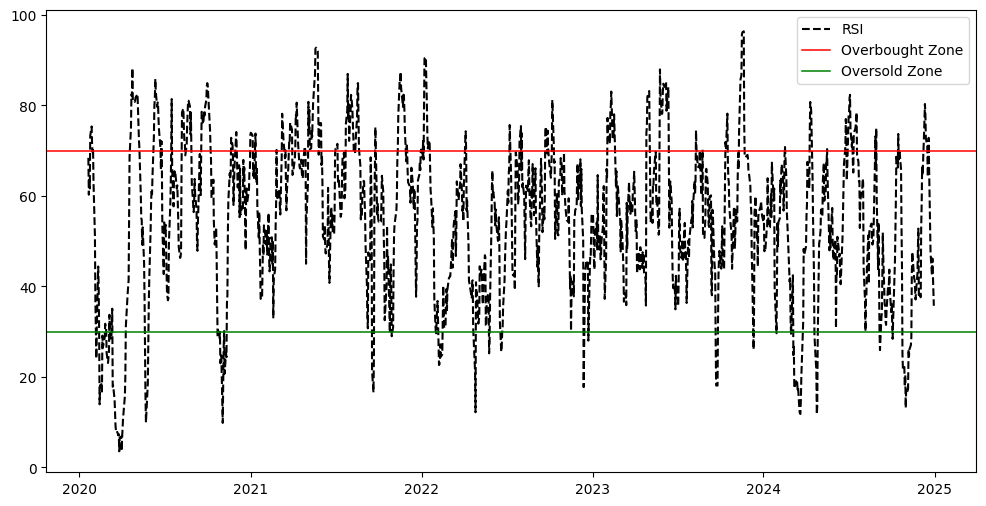

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df['RSI'],label='RSI',linewidth=1.5,linestyle='--',color='Black')
plt.axhline(70,label='Overbought Zone',color='Red',linewidth=1.1)
plt.axhline(30,label='Oversold Zone',color='Green',linewidth=1.1)
plt.legend()
plt.show()

In [13]:
# Bollinger Bands -> Another indicator to track volatility, 
# Bands expands farway when there's more volatile, contracts if price movement is stable
# calculated as Upper Band = SMA + (2*Std.Deviation) & Lower Band = SMA -(2*Std.Deviation)

def Bollinger_Cal(data,window=20,size=2):
    SMA=data.rolling(window=window).mean()
    STD=data.rolling(window=window).std()
    Upper_Band=SMA + (size*STD)
    Lower_Band=SMA - (size*STD)
    return SMA,Upper_Band,Lower_Band
SMA,Upper_Band,Lower_Band=Bollinger_Cal(df['Close'])
df['Bollinger_MA20']=SMA
df['Upper_Band']=Upper_Band
df['Lower_Band']=Lower_Band

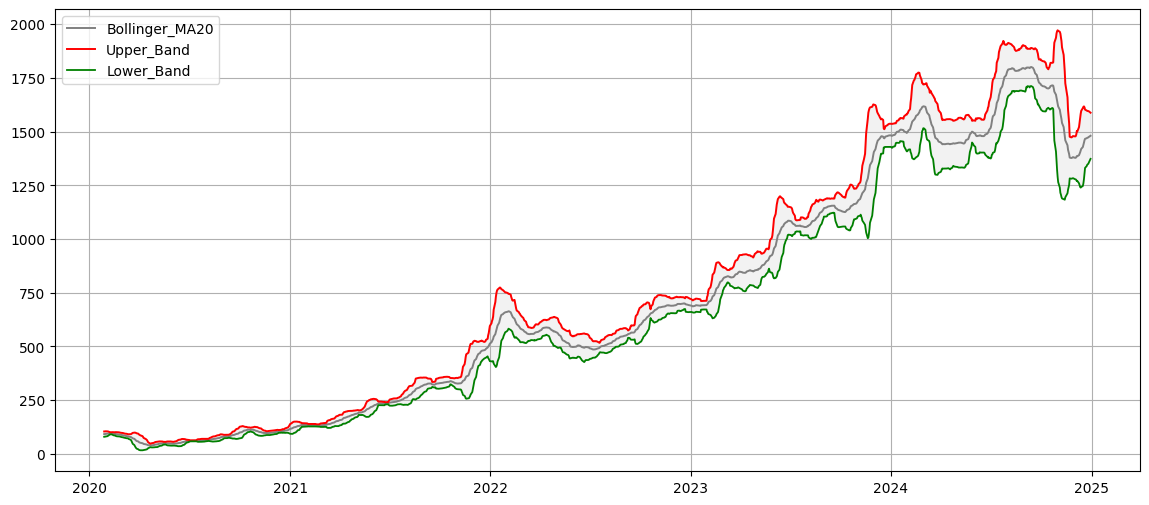

In [14]:
# Plot Bollinger Band
plt.figure(figsize=(14,6))
plt.plot(df['Bollinger_MA20'],label='Bollinger_MA20',color='Grey',linewidth=1.4)
plt.plot(df['Upper_Band'],label='Upper_Band',color='Red',linewidth=1.4)
plt.plot(df['Lower_Band'],label='Lower_Band',color='Green',linewidth=1.3)
plt.fill_between(df.index,df['Lower_Band'],df['Upper_Band'],color='Grey',alpha=0.1)
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def Signal(df):
    df['Signal']=0
    df.loc[
    (df['RSI'] < 70) &
    (df[('Close','KPITTECH.NS')] < df['Lower_Band']) &
    (df[('Close','KPITTECH.NS')] > df['30 EMA']),
    'Signal'
    ] = 1
    df.loc[
        (df[('Close','KPITTECH.NS')]>df['Upper_Band']) &
        (df['30 EMA']>df[('Close','KPITTECH.NS')]) &
        (df['RSI']>30),'Signal'
    ]=-1
    return df
df=Signal(df)

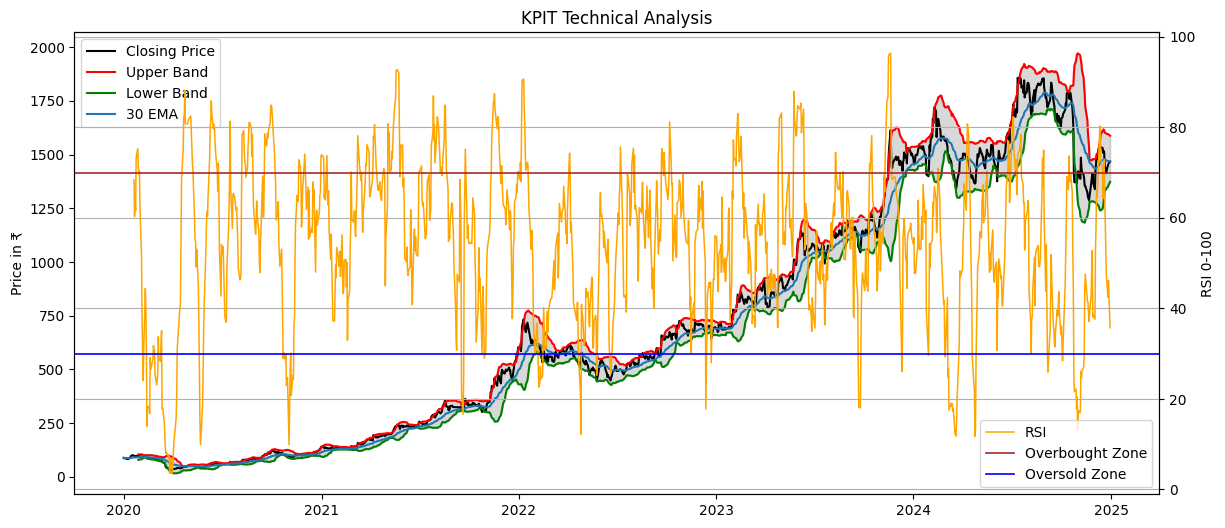

In [16]:
fig,ax1=plt.subplots(figsize=(14,6))

ax1.plot(df['Close'],label='Closing Price',color='Black',linewidth=1.5)
ax1.plot(df['Upper_Band'],label='Upper Band',color='Red',linewidth=1.5)
ax1.plot(df['Lower_Band'],label='Lower Band',color='Green',linewidth=1.5)
ax1.plot(df['30 EMA'],label='30 EMA',linewidth=1.5)
ax1.fill_between(df.index,df['Upper_Band'],df['Lower_Band'],color='Grey',alpha=0.3)
ax1.set_ylabel('Price in ₹')
ax1.legend()

ax2=ax1.twinx()
ax2.plot(df['RSI'],label='RSI',color='Orange',linewidth=1.1)
ax2.axhline(70,label='Overbought Zone',color='Brown',linewidth=1.2)
ax2.axhline(30,label='Oversold Zone',color='Blue',linewidth=1.2)
ax2.set_ylabel('RSI 0-100')
ax2.legend(loc='lower right')

plt.grid(True)
plt.title('KPIT Technical Analysis')

plt.show()

In [17]:
#Z-Score -> Bollinger Band is actually based on this principle, 
           # used to find how many std. deviation is the given price is away

def Z_Score_Cal(data,window=20):
    df['rolling_mean']=data.rolling(window=20).mean()
    df['std_']=data.rolling(window=20).std()
    return ((df[('Close','KPITTECH.NS')] - df['rolling_mean'])/df['std_'])
df['Z-Score']=Z_Score_Cal(df[('Close','KPITTECH.NS')])

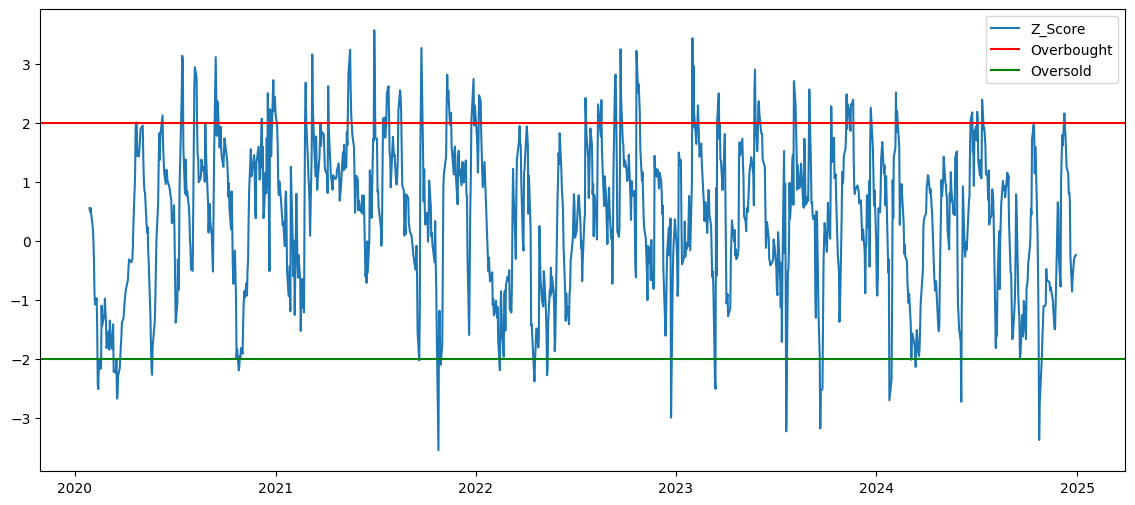

In [26]:
plt.figure(figsize=(14,6))
plt.plot(df['Z-Score'],label='Z_Score',linewidth='1.5')
plt.axhline(2,label='Overbought',color='Red')
plt.axhline(-2,label='Oversold',color='Green')
plt.legend()
plt.show()

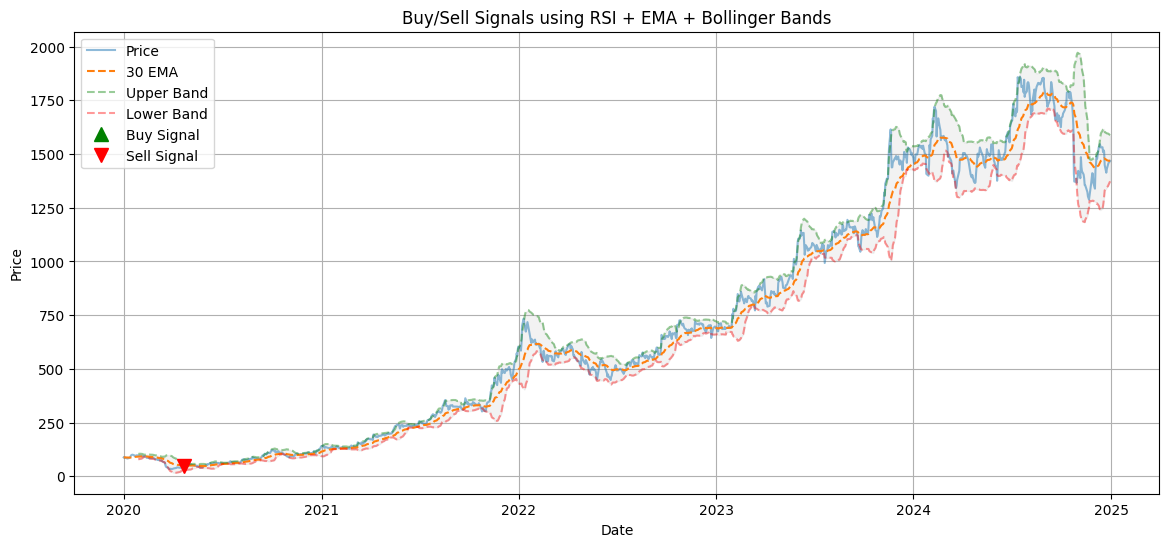

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Price', alpha=0.5)
plt.plot(df['30 EMA'], label='30 EMA', linestyle='--')
plt.plot(df['Upper_Band'], label='Upper Band', color='green', linestyle='--', alpha=0.4)
plt.plot(df['Lower_Band'], label='Lower Band', color='red', linestyle='--', alpha=0.4)
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.1)

# Plot Buy signals
plt.plot(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Close'], '^', color='green', markersize=10, label='Buy Signal')

# Plot Sell signals
plt.plot(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Close'], 'v', color='red', markersize=10, label='Sell Signal')

plt.title('Buy/Sell Signals using RSI + EMA + Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
